<a href="https://colab.research.google.com/github/Gyeong-Hyeon/AI_Project/blob/main/Section2/AI_01_%EC%97%BC%EA%B2%BD%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap

In [ ]:
from IPython.display import display
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score, accuracy_score
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
import warnings

#**1. 데이터 전처리 및 랭글링** 

##**👩🏻‍💻 데이터 준비하기**

In [2]:
#데이터를 불러옵니다.
patient_21 = pd.read_excel('https://docs.google.com/spreadsheets/d/e/2PACX-1vQDLQ5Bdj7692BU0e1EwsEyG2h5cpyt8pcrXOQ3uOQixIQ4Qbrn5d6jX5WnxeNpWr3mrECiXgPWfkWf/pub?output=xlsx')
vacc_21 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTr60lC-MNfPA_PgY7NjtFPuV_uEgN5uETLUSJkeoruTZyluDhxzY8D0JVF4bijkbFJv6E2QNC2zZku/pub?output=csv')
patient_20 = pd.read_excel('https://docs.google.com/spreadsheets/d/e/2PACX-1vQPFCXNVr0_zL5L-vJl5IMSwCfxBiBrWbeaN5RlN-zlSBer4YkloBnvtVbc4nnGQw/pub?output=xlsx')
vacc_20 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSbKt4I1BVWLqB6FyWAfcWr7lCFctvWd4b4C7YHNtcA9znBT-cs15Q1NM7ToBs5aczuX2_hK28KO6wA/pub?output=csv')

#2020년 환자 데이터에 'LAB_DATA'라는 중복되지않은 컬럼을 삭제하겠습니다.
patient_20 = patient_20.drop(columns= 'LAB_DATA')

#2020년과 2021년 데이터를 합쳐줍니다.
patient = pd.concat([patient_20,patient_21])
vacc = pd.concat([vacc_20,vacc_21])

dfs = [patient, vacc]

for df in dfs:
      print(df.shape)
      display(df.head())
      print('\n')

(16442, 34)


,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,902440.0,12/15/2020,AZ,35.0,35.0,NaN,F,NaN,C/O Headache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/15/2020,12/15/2020,0.0,PVT,NaN,NaN,NaN,NaN,NaN,NaN,2.0,12/15/2020,NaN,NaN,NaN,NaN
1,902446.0,12/15/2020,WV,55.0,55.0,NaN,F,NaN,"felt warm, hot and face and ears were red and ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/15/2020,12/15/2020,0.0,OTH,NaN,"Novasc, Hydrochlorothiazide, synthroid, lisino...",none,"Hypertension, sleep apnea, hypothyroidism",NaN,NaN,2.0,12/15/2020,NaN,NaN,NaN,"Contrast Dye IV contrast, shellfish, strawberry"
2,902448.0,12/15/2020,IL,NaN,NaN,NaN,U,NaN,stroke; neuropathy; post herpetic neuralgia; c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,N,08/10/2015,NaN,NaN,UNK,NaN,NaN,Routine health maintenance,NaN,NaN,US0095075132012USA004082,2.0,12/15/2020,NaN,Y,NaN,NaN
3,902449.0,12/15/2020,NC,51.0,51.0,NaN,F,NaN,the worst RA pain ever; flu-like symptoms; fev...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,11/30/2020,11/30/2020,0.0,UNK,NaN,NaN,Crohn's disease; Ehlers-Danlos syndrome; Fibro...,NaN,NaN,USGLAXOSMITHKLINEUS2020AM,2.0,12/15/2020,NaN,NaN,Y,NaN
4,902450.0,12/15/2020,GA,67.0,67.0,NaN,F,NaN,Fluid in Lungs; foot Swelling; Difficulty brea...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,11/23/2020,11/23/2020,0.0,UNK,NaN,NaN,NaN,NaN,NaN,USGLAXOSMITHKLINEUS202023,2.0,12/15/2020,NaN,NaN,Y,NaN




(59078, 8)


,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,855017,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,2,SYR,LA,ZOSTER (SHINGRIX)
1,855018,UNK,UNKNOWN MANUFACTURER,NaN,1,IM,RA,VACCINE NOT SPECIFIED (OTHER)
2,855019,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX)
3,855020,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,IM,LA,ZOSTER (SHINGRIX)
4,855021,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,2,IM,RA,ZOSTER (SHINGRIX)


* Patient: 환자의 정보가 담긴 데이터 셋
* Vacc: 백신 정보가 담긴 데이터 셋

💊VAERS_ID (고유 번호)를 기준으로 두 데이터를 합칠 수 있습니다.
각 데이터별로 중복된 ID가 있는지 먼저 확인 해보겠습니다.

In [3]:
#백신 데이터를 Covid 백신으로만 소팅합니다

mask = vacc['VAX_TYPE'].isin(['COVID19'])
covid_vac = vacc[mask]
print('Length of Covid vaccine dataset:',len(covid_vac))

#Covid 백신 데이터 셋의 VAERS_ID열에 중복된 데이터가 있는지 확인합니다.
print('Duplicated VAERS ID in Covid vaccine dataset:',covid_vac.duplicated(['VAERS_ID']).sum())
mask = covid_vac.duplicated(['VAERS_ID'])
covid_duplicated = covid_vac[mask]
covid_duplicated['VAERS_ID'].unique()

Length of Covid vaccine dataset: 14337
Duplicated VAERS ID in Covid vaccine dataset: 78


array([ 905340,  906428,  907330,  907837,  909370,  909520,  911085,
        912442,  912896,  913038,  913869,  914017,  914458,  937480,
        938126,  938576,  943614,  944595,  945504,  946663,  948418,
        949732,  950911,  957227,  959928,  962110,  963587,  964617,
        967274,  968195,  970198,  970515,  971567,  971939,  973816,
        974177,  975206,  978768,  983425,  984929,  988246,  989556,
        990109,  990118,  990694,  990702,  990718,  991686,  992082,
        992774,  994007,  995346,  995419,  996577, 1000418, 1000733,
       1000849, 1003553, 1005737, 1006745, 1007357, 1007628, 1007928,
       1008767, 1009424, 1011689, 1011707, 1011983, 1015253, 1015465,
       1015921, 1016770, 1016907, 1019670, 1020144, 1020227, 1022397,
       1024343])

* **백신 데이터 중복 VAERS_ID:** 46개
* **중복되는 경우**

1. 같은 환자에게 다른 종류의 백신 접종 ⭐

2. 같은 환자에게 다른 Lot의 백신 접종 → drop

3. 백신 루트나 백신 접종 지역이 다름 → drop

In [ ]:
ids = [905340,  906428,  907330,  907837,  909370,  909520,  911085, 912442,  912896,  913038,  913869,  914017,  914458,  937480, 938126,  938576,  943614,  944595,  945504,  946663,  948418,
        949732,  950911,  957227,  959928,  962110,  963587,  964617, 967274,  968195,  970198,  970515,  971567,  971939,  973816, 974177,  975206,  978768,  983425,  984929,  988246,  989556,
        990109,  990118,  990694,  990702,  990718,  991686,  992082, 992774,  994007,  995346,  995419,  996577, 1000418, 1000733, 1000849, 1003553, 1005737, 1006745, 1007357, 1007628, 1007928,
       1008767, 1009424, 1011689, 1011707, 1011983, 1015253, 1015465, 1015921, 1016770, 1016907, 1019670, 1020144, 1020227, 1022397, 1024343]

for id in ids:
  mask = covid_vac['VAERS_ID'].isin([id])
  mask = covid_vac[mask]
  if len(mask['VAX_NAME'].unique()) == 1:
    pass
  else:
    print(mask[['VAERS_ID', 'VAX_DOSE_SERIES','VAX_NAME']],'\n')

       VAERS_ID VAX_DOSE_SERIES                             VAX_NAME
51963    912896               2          COVID19 (COVID19 (MODERNA))
51964    912896               1  COVID19 (COVID19 (PFIZER-BIONTECH)) 

      VAERS_ID VAX_DOSE_SERIES                             VAX_NAME
2524    967274             UNK          COVID19 (COVID19 (MODERNA))
2525    967274             UNK  COVID19 (COVID19 (PFIZER-BIONTECH)) 



* 같은 백신을 투약한 VAERS_ID: 44개 (drop)

* 다른 백신을 투약한 VAERS_ID: 912896, 967274

In [ ]:
duplicated = patient[patient['VAERS_ID'].isin([912896,967274])]
for id,symp in zip(duplicated['VAERS_ID'],duplicated['SYMPTOM_TEXT']):
  print('Patient#',id, symp)

Patient# 912896 patient received a dose of Moderna vaccine after receiving the Pfizer vaccine.
Patient# 967274 I was pregnant and my baby died two days after I took it and I got really sick


912896은 접종 후에 대한 증상이나 사망 여부 등 특별한 정보가 없으므로 삭제하겠습니다.

967274는 태아가 죽은 것으로 확인 되나, 모더나와 화이자 중 어느 백신의 영향인지 알 수 없으므로 삭제하겠습니다.

In [ ]:
print('Duplicated VAERS ID in Patient dataset:',patient.duplicated(['VAERS_ID']).sum())

Duplicated VAERS ID in Patient dataset: 0


In [4]:
covid = covid_vac[['VAERS_ID','VAX_MANU']]
covid = covid.drop_duplicates(['VAERS_ID'])
covid = pd.merge(covid, patient, on = ['VAERS_ID'], how = 'inner')
print('기존 환자 수:',len(patient),'\nCovid백신을 접종한 환자 수:',len(covid))

기존 환자 수: 16442 
Covid백신을 접종한 환자 수: 14257


##**👩🏻‍💻 데이터 전처리**


1. 결측치 정리 & 카디널리티 조정

2. 타겟 만들기

3. 상관관계를 통한 특성 분석

4. 필요 없는 column drop



###💉 결측치 정리 & 카디널리티 조정

In [ ]:
covid.isnull().sum()

VAERS_ID            0
VAX_MANU            0
RECVDATE            0
STATE            1773
AGE_YRS          1372
CAGE_YR          3539
CAGE_MO         14215
SEX                 0
RPT_DATE        14077
SYMPTOM_TEXT        0
DIED            13457
DATEDIED        13516
L_THREAT        13647
ER_VISIT        14236
HOSPITAL        12406
HOSPDAYS        13059
X_STAY          14241
DISABLE         13941
RECOVD           1119
VAX_DATE          571
ONSET_DATE        687
NUMDAYS          1136
V_ADMINBY           3
V_FUNDBY        14075
OTHER_MEDS       5653
CUR_ILL          7329
HISTORY          4754
PRIOR_VAX       13709
SPLTTYPE        10332
FORM_VERS           0
TODAYS_DATE       261
BIRTH_DEFECT    14232
OFC_VISIT       12367
ER_ED_VISIT     11089
ALLERGIES        9803
dtype: int64

In [5]:
previous = covid['AGE_YRS'].isnull().sum()
covid['AGE_YRS'] = np.where(pd.notnull(covid['AGE_YRS']) == True, covid['AGE_YRS'], covid['CAGE_YR'])
current = covid['AGE_YRS'].isnull().sum()
print('CAGE_YR을 통해', previous-current,'개의 결측값을 채웠으며, 현재 나이 특성의 결측치 갯수는',current,'개입니다.')

CAGE_YR을 통해 78 개의 결측값을 채웠으며, 현재 나이 특성의 결측치 갯수는 1294 개입니다.


성별의 경우, 결측치는 없으나 'U'가 undefinded이므로 결측치라고 생각할 수 있습니다. 따라서 symptom을 통해 환자의 성별을 추측해보겠습니다.

In [6]:
previous = covid.SEX.isin(['U']).sum()
data = covid.copy()
data['split_symp'] = data.SYMPTOM_TEXT.str.split(' ')
new_sex = []
for symptom, sex in zip(data['split_symp'], data['SEX']):
  if 'foetal' in symptom or 'Foetal' in symptom or 'fetal' in symptom or 'fetus' in symptom:
    new_sex.append('fetus')
  elif sex == None or sex == 'U':
    if 'she' in symptom or 'She' in symptom or 'woman' in symptom or 'female' in symptom or 'Female' in symptom or 'Her' in symptom or 'her' in symptom:
      new_sex.append('F')
    elif 'he' in symptom or 'He' in symptom or 'man' in symptom or 'male' in symptom or 'Male' in symptom or 'His' in symptom or 'his' in symptom:
      new_sex.append('M')
    else:
      new_sex.append(sex)
  else: 
    new_sex.append(sex)

covid['SEX'] = new_sex
current = covid.SEX.isin(['U']).sum()
print('증상 컬럼을 통해',previous-current,'개의 성별을 확인했으며, 현재 성별의 결측치 수는',current,'입니다.')   

증상 컬럼을 통해 78 개의 성별을 확인했으며, 현재 성별의 결측치 수는 369 입니다.


백신 투약 날짜의 결측치는 on set date(보고된 날짜)로 채우고 카디널리티를 낮추기 위해 월로 변경하겠습니다.

In [7]:
previous = covid['VAX_DATE'].isnull().sum()

#VAX_DAT와 ONSET_DATE 열을 날짜 형식으로 변경해줍니다.
data = covid.copy()
def date(df):
  new_date = []
  for date in df:
    if type(date) == str or type(date) == float:
      new_date.append(date)
    else:
      date = date.strftime('%m/%d/%Y')
      new_date.append(date)
  return new_date

data.VAX_DATE = date(data.VAX_DATE)
data.ONSET_DATE = date(data.ONSET_DATE)

covid.VAX_DATE = pd.to_datetime(data['VAX_DATE'], format="%m/%d/%Y", errors='raise')
covid.ONSET_DATE = pd.to_datetime(data['ONSET_DATE'], format="%m/%d/%Y", errors='raise')

#ONSET_DATE를 통해 결측치를 채웁니다.
covid['VAX_DATE'] = np.where((pd.notnull(covid['VAX_DATE'])== True), covid['VAX_DATE'], covid['ONSET_DATE'])

current = covid['VAX_DATE'].isnull().sum()
print('ONSET_DATE컬럼을 통해', previous-current,'개의 결측값을 채웠으며, 현재 백신 접종 날짜의 결측치 갯수는',current,'개입니다.')

ONSET_DATE컬럼을 통해 66 개의 결측값을 채웠으며, 현재 백신 접종 날짜의 결측치 갯수는 505 개입니다.


In [8]:
#백신 접종 날짜를 월로 변경해 카디널리티를 낮추겠습니다.

covid.VAX_DATE = covid.VAX_DATE.dt.month
covid.VAX_DATE.unique()

array([12., 11.,  7., nan,  9.,  1., 10.,  2.,  4.,  6.,  8.,  3.,  5.])

###💉 타겟 만들기

타겟은 Death, Disabled, Recovered 컬럼을 활용해 백신을 투약한 환자가 사망 또는 부작용이 있었는지 확인 해 보겠습니다.

💊 Death 또는 Disabled가 Y이면 target = 1

💊 Recovered 가 Y이면 target = 0

In [9]:
target = []
for death, disabled, recovered in zip(covid.DIED, covid.DISABLE, covid.RECOVD):
  if death == 'Y':
    target.append(1)
  elif disabled == 'Y':
    target.append(1)
  elif recovered == 'Y':
    target.append(0)
  elif recovered == 'N':
    target.append(1)
  else:
    target.append(None)

covid['target'] = target
covid.target.value_counts()

1.0    5084
0.0    5081
Name: target, dtype: int64

In [10]:
#타겟의 결측치는 drop하겠습니다.
covid.dropna(subset=['target'], inplace=True)
len(covid)

10165

###💉 상관관계를 통한 특성 분석

투약 백신 제조사, 환자의 병력, 기타 약물 사용 여부, 알러지 여부와 타겟과의 상관관계 분석

In [ ]:
import plotly.offline as pyo
import plotly.graph_objs as go

df = covid.groupby('VAX_MANU')['target'].value_counts(normalize=True).unstack().reset_index()
df = df.melt(id_vars = ['VAX_MANU'], value_vars = [0.0,1.0])

trace1 = go.Bar(x=df[df.target == 0].VAX_MANU, y=df[df.target == 0].value, name='NOT RECOVERED')
trace2 = go.Bar(x=df[df.target == 1].VAX_MANU, y=df[df.target == 1].value, name='RECOVERED')

data = [trace1, trace2]
layout = go.Layout(title='제조사별 회복 환자 비율')
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

In [ ]:
df = covid.groupby('target')['VAX_MANU'].value_counts(normalize=True).unstack().reset_index()
df = df.melt(id_vars = ['target'], value_vars = ['MODERNA','PFIZER\BIONTECH','UNKNOWN MANUFACTURER'])

trace1 = go.Bar(x=df[df.VAX_MANU == 'MODERNA'].target, y=df[df.VAX_MANU == 'MODERNA'].value, name='MODERNA')
trace2 = go.Bar(x=df[df.VAX_MANU == 'PFIZER\BIONTECH'].target, y=df[df.VAX_MANU == 'PFIZER\BIONTECH'].value, name='PFIZER')
trace3 = go.Bar(x=df[df.VAX_MANU == 'UNKNOWN MANUFACTURER'].target, y=df[df.VAX_MANU == 'UNKNOWN MANUFACTURER'].value, name='UNKNOWN')

data = [trace1, trace2, trace3]
layout = go.Layout(title= '회복여부 별 제조사 비율')
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

모더나는 총 접종한 환자 중 회복하지 못한 환자들의 비율이 더 높은데 비해, 화이자는 근소하게 회복한 환자의 비율이 더 높은 것을 확인 할 수 있습니다.
또한, 제조사가 확인되지 않은 백신은 압도적으로 회복하지 못한 환자들의 비율이 높은 것을 확인 할 수 있습니다.

회복 여부별로 보면 두 집단 모두에서 화이자가 높은 비율을 차지하고 있는 것을 확인 할 수 있습니다.

In [11]:
#No라고 간주할 수 있는 답변 list입니다.
no = ['N','None','none','unknown','Unknown','No','no','NONE','UNKOWN','N/a','; ;','NO','; ; ;','None known','None reported','not known','None listed','Not known','none reported','NONE KNOWN',
      'na','Nothing','None.','denies','None Known','?','Unsure','not reported','none given','Na','-','None that day.','Nothing new, and no change.','nothing','No current medications',
      'Zero','None of','Non','I am on no prescription drugs.','NOT AVAILABLE','none.','UNKNOWN','Nothing','none known','No known allergies.','none listed','None reported.','None disclosed',
      'None known.','None noted.','not applicable','None!','no significant past medical history','Uniknown','none stated','None - I am healthly','not listed on the report','no significant medical history',
      'None Listed','None noted','None charted','none listed on health intake form','None that we are aware of','No known chronic conditions','none listed- no','no chronic health condition',
      'None Noted','no chronic health conditions','not reported','none revealed on consent form','None , obesity 290 lbs.','none known at that time','None stated/Denied','None, childhood asthma',
      'None overall no acute medical conditions.','None until vaccine','no.','Unknown at this time','None indicated on consent form','No known','unknown, still investigating','None of these.',
      'Not applicable','no,','none (anxiety)','none3','Not in the record','none that was reported','Not Sure','NKA','No known drug/food allergies','NKDA at the time','No known Allergies','No know allergies',
      'None that I know of','NKDA, NKA','no allergies','NKDA, NKFA','No Known Drug Allergies','No known drug allergies','No known allergies to drugs or food','NKA listed on form',
      'No known defined allergies.','unknown. Denied allergies on vaccine form','NKA, NKDA','Nnone','Unknow','None at this time','no known allergies recorded in medical record','-none-',
      'none that we know of','unknown - no','NKA to medications','NKA to medications','No known drug or food allergies',"none that I'm aware",'None stated/Denied','No known allergy','No previous known Allergies',
      'Allergies: NKDA','None that I am aware of.','None Reported','NONE NKDA','NKA.','pt answered no','Not on File','Not aware','NKDA & NO FOOD ALLERGIES','Not that I know.',
      'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: none','Medical History/Concurrent Conditions: No adverse event (No reported medical history)']

new = []

#특성 중 회복력이 좋은 약물 순서로 높은 점수를 주겠습니다.
for value in covid.OTHER_MEDS.values:
  if type(value)==float:
    new.append(None)
  elif 'cholesterol' in value or 'Cholesterol' in value or 'CRESTOR' in value: #고지혈증
    new.append(2)
  elif 'pressure' in value or 'METOPROLOL' in value or 'metoprolol' in value: #고혈압, 제2형 당뇨병
    new.append(3)  
  elif 'Metformin' in value or 'metformin' in value: #당뇨
    new.append(4)
  elif 'Protonix' in value: #위염
    new.append(5)  
  elif 'Adderall' in value or 'adderall' in value or 'ADHD' in value: #ADHD
    new.append(6)
  elif 'ADVAIR' in value or 'advair' in value or 'Advair' in value: #천식
    new.append(7)
  elif 'CLARITIN' in value or 'claritin' in value: #알레르기
    new.append(8)    
  elif 'Zyrtec' in value or 'zyrtec' in value or 'FLONASE' in value or 'flonase' in value: #비염
    new.append(9)
  elif 'Wellbutrin' in value or 'wellbutrin' in value or 'Zoloft' in value or 'zoloft' in value or 'Lexapro' in value or 'lexapro' in value or 'Cymbalta' in value: #우울증치료제
    new.append(10)
  elif 'Lisinopril' in value or 'lisinopril' in value or 'cardiac' in value or 'Cardiac' in value: #심부전증
    new.append(11)
  elif 'Synthroid' in value or 'synthroid' in value or 'SYNTHROID' in value or 'Levothyroxine' in value or 'levothyroxine' in value or 'LEVOTHYROXINE' in value or 'Levoxyl' in value or 'levoxyl' in value: #갑상선
    new.append(12)
  elif 'Tylenol' in value or 'tylenol' in value or 'TYLENOL' in value or 'Ibuprofen' in value or 'ibuprofen' in value or 'motrin' in value: #소염진통제
    new.append(13)
  elif 'Birth control' in value or 'birth control' in value or 'birthcontrol' in value or 'BIRTH CONTROL' in value or 'IUD' in value or 'OCP' in value: #피임
    new.append(14)
  elif 'vitamin' in value or 'Vitamin' in value or 'VITAMIN' in value or 'vitamins' in value or 'Vitamins' in value or 'VITAMINS' in value:
    new.append(15)
  elif value in no:
    new.append(0)
  else:
    new.append(1)

covid.OTHER_MEDS = new
covid['OTHER_MEDS'].unique()

array([nan, 11.,  0., 10.,  1., 15., 14., 13.,  4., 12.,  5.,  9.,  6.,
        3.,  7.,  2.,  8.])

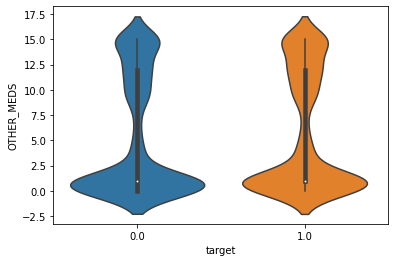

In [ ]:
sns.violinplot(x=covid.target, y=covid.OTHER_MEDS);

크게 설명력이 있는 특성 같아 보이지는 않습니다.

In [12]:
new = []

for value in covid.HISTORY.values:
  if type(value)==float:
    new.append(None)
  elif type(value) == int:
    new.append(1)
  elif 'Tachycardia' in value or 'tachycardia' in value: #빈맥
    new.append(2)
  elif 'sclerosis' in value: #경화증
    new.append(3)
  elif 'Dementia' in value or 'dementia' in value: #치매
    new.append(4)  
  elif 'Hypothyroidism' in value or 'hypothyroidism' in value: #갑상선기능저하증
    new.append(5)
  elif 'obesity' in value or 'Obesity' in value: #비만
    new.append(6)  
  elif 'Diabetes' in value or 'diabetes' in value: #당뇨
    new.append(7)
  elif 'Ulcerative colitis' in value: #대장염
    new.append(8)
  elif 'cholesterol' in value or 'Cholesterol' in value: #고지혈증
    new.append(9)
  elif 'Eczema' in value: #습진
    new.append(10)
  elif 'Fibromyalgia' in value or 'fibromyalgia' in value: #섬유근육통
    new.append(11)
  elif 'blood prssure' in value or 'Blood pressure' in value: #저혈압/ 고혈압
    new.append(12)
  elif 'allergy' in value or 'allergies' in value or 'Asthma' in value or 'asthma' in value: #천식, 알레르기
    new.append(13)
  elif 'Osteoporosis' in value or 'Rheumatoid Arthritis' in value: #골다공증,관절염
    new.append(14)
  elif 'COVID-19' in value:
    new.append(15)
  elif value in no:
    new.append(0)
  else:
    new.append(1)

covid.HISTORY = new
covid['HISTORY'].unique()

array([nan,  5.,  0., 11.,  1., 13.,  7.,  9.,  6., 12., 14.,  2.,  4.,
       10.,  8., 15.,  3.])

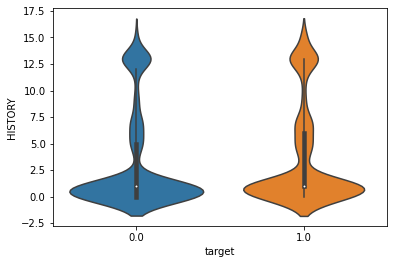

In [ ]:
sns.violinplot(x=covid.target, y=covid.HISTORY);

기타약물복용여부보다는 아주 조금 더 설명력이 있는 것 같습니다.

In [13]:
visit_er = []

covid.ER_ED_VISIT = covid.ER_ED_VISIT.fillna('N')

for er, ed in zip(covid.ER_VISIT, covid.ER_ED_VISIT):
  if ed == 'N':
    visit_er.append(er)
  else:
    visit_er.append(ed)

covid.ER_ED_VISIT = visit_er
current = covid.ER_ED_VISIT.isnull().sum()
print('ER_VISIT 컬럼을 통해', 7823-current,'개의 결측값을 채웠으며, 현재 응급실 방문 여부의 결측치 갯수는',current,'개입니다.')

ER_VISIT 컬럼을 통해 4 개의 결측값을 채웠으며, 현재 응급실 방문 여부의 결측치 갯수는 7819 개입니다.


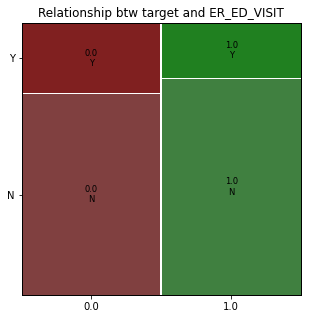

In [15]:
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt

covid['ER_ED_VISIT'] = covid['ER_ED_VISIT'].fillna('N')

plt.rcParams["figure.figsize"]=(5, 5)
mosaic(covid.sort_values('target'), ['target','ER_ED_VISIT'])
plt.title('Relationship btw target and ER_ED_VISIT')
plt.show()

응급실에 방문한 사람은 완치율이 더 좋은 것 같습니다. 따라서 응급실에 방문한 사람을 0, 방문하지 않은 사람을 1로 encoding하겠습니다.

In [16]:
covid.ER_ED_VISIT = covid.ER_ED_VISIT.replace({'Y':0,'N':1})
covid.ER_ED_VISIT.unique()

array([1, 0])

In [17]:
new = []

for value in covid.ALLERGIES.values:
  if type(value)==float:
    new.append(None)
  elif type(value)== int:
    new.append(0)
  elif 'Rocephin' in value: #폐렴
    new.append(2)
  elif 'Reglan' in value: #위염, 소화
    new.append(3)
  elif 'Biaxin' in value:
    new.append(4)  
  elif 'seasonal allergies' in value:
    new.append(5)
  elif 'Lactose' in value or 'lactose' in value: #젖당
    new.append(6)  
  elif 'shellfish' in value:
    new.append(7)
  elif 'augmentin' in value or 'cephalexin' in value: #항균제
    new.append(8)
  elif 'Bee stings' in value or 'bee stings' in value:
    new.append(9)
  elif 'Iodine' in value: #요오드 (갑상선)
    new.append(10)
  elif 'Lisinopril' in value or 'lisinopril' in value or 'Losartan' in value: #고혈압
    new.append(11)
  elif 'Codeine' in value or 'codeine' in value or 'CODEINE' in value or 'Morphine' in value or 'morphine' in value or 'Aleve' in value: #진통제
    new.append(12)
  elif 'Latex' in value or 'latex' in value:
    new.append(13)
  elif 'Sulfa' in value or 'sulfa' in value:
    new.append(14)
  elif 'Penicillin' in value or 'penicillin' in value or 'penicillins' in value or 'Penicillins' in value or 'PENICILLIN' in value or 'PCN' in value or 'pcn' in value or 'Amoxicillin' in value or 'amoxicillin' in value or 'Erythromycin' in value: #페니실린류
    new.append(15)
  elif value in no:
    new.append(0)
  else:
    new.append(1)

covid.ALLERGIES = new
covid['ALLERGIES'].unique()

array([nan,  7.,  0.,  4.,  1., 12., 10., 14., 15., 13., 11.,  5.,  2.,
        9.,  6.,  3.,  8.])

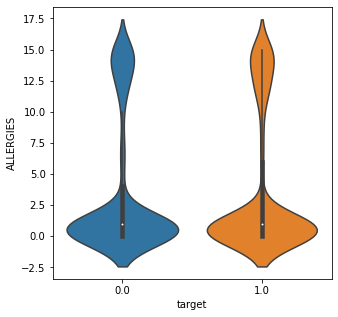

In [ ]:
sns.violinplot(x=covid.target, y=covid.ALLERGIES);

알레르기 역시 큰 설명력이 있어보이지는 않습니다.

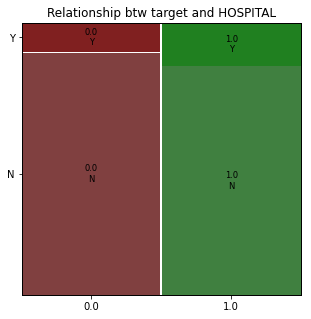

In [18]:
covid['HOSPITAL'] = covid['HOSPITAL'].fillna('N')

plt.rcParams["figure.figsize"]=(5, 5)
mosaic(covid.sort_values('target'), ['target', 'HOSPITAL'])
plt.title('Relationship btw target and HOSPITAL')
plt.show()

병원에 입원한 환자들은 입원하지 않은 환자들보다 사망할 확률이 높은 것으로 보입니다. 아무래도 중증인 환자들이 입원을 하기 때문일 거라 추측됩니다.

In [25]:
covid.HOSPITAL = covid.HOSPITAL.replace({'Y':0,'N':1})
covid.HOSPITAL.unique()

array([1, 0])

###💉 필요없는 특성 drop하기

대부분의 특성은 일단 사용하고, 모델을 만든 후 특성 중요도를 확인해보겠습니다.

In [26]:
id = covid['VAERS_ID']
data = covid.drop(columns=['VAERS_ID', 'RECVDATE', 'STATE', 'CAGE_YR', 'CAGE_MO', 'RPT_DATE', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT', 'HOSPDAYS', 'X_STAY', 'DISABLE',
       'RECOVD', 'ONSET_DATE', 'NUMDAYS', 'V_ADMINBY', 'V_FUNDBY', 'CUR_ILL', 'PRIOR_VAX', 'SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT'])

In [27]:
#한 열에 결측치가 네 개 이상인 열은 삭제하겠습니다.

data = data[(data.isnull().sum(axis=1) <= 3)]
len(data)

9966

#**2. Baseline 모델 및 평가지표 정하기, 데이터셋 나누기** 

분류 문제이기 때문에 baseline 모델은 타겟의 최빈 클래스인 0으로 대답하는 모델입니다.
class별 비율 차이가 크지 않기 때문에 accuracy를 평가지표로 사용해도 되지만, f1 score도 함께 보겠습니다.

In [21]:
target = 'target'

In [ ]:
#타겟의 최빈클래스를 기준으로 baseline model을 만들어줍니다.
baseline = data[target].mode()[0]
baseline_pred = [baseline] * len(data)

#Classification report를 출력합니다
print(classification_report(data[target], baseline_pred))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      5000
         1.0       0.00      0.00      0.00      4966

    accuracy                           0.50      9966
   macro avg       0.25      0.50      0.33      9966
weighted avg       0.25      0.50      0.34      9966



Baseline 모델은 모든 사람들이 회복을 할 것이라고 예측했습니다. 해당 모델의 accuracy는 0.5, f1 score는 0 입니다.

In [28]:
#데이터 셋은 train:val:test = 7:1.5:1.5로 나누겠습니다.
train_splited, val_splited = train_test_split(data, test_size=0.3, stratify=data[target], random_state=10)
val_splited, test_splited = train_test_split(val_splited, test_size=0.5, stratify=val_splited[target], random_state=10)

features = data.drop(columns=target).columns

X_train = train_splited[features]
y_train = train_splited[target]
X_val = val_splited[features]
y_val = val_splited[target]
X_test = test_splited[features]
y_test = test_splited[target]

print('훈련 데이터 개수:',len(y_train),',검증 데이터 개수:',len(y_val),',테스트 데이터 개수:',len(y_test))

훈련 데이터 개수: 6976 ,검증 데이터 개수: 1495 ,테스트 데이터 개수: 1495


#**3. 모델 만들기** 

##👩🏻‍💻**첫 번째 모델**

* **Imputer:** iterative_imputer
* **Encoder:** target encoder
* **Model:** Random Forest


In [ ]:
warnings.filterwarnings(action='ignore')

pipe = make_pipeline(
    TargetEncoder(), 
    IterativeImputer(), 
    RandomForestClassifier(random_state=10)
)

dists = {
    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.],
    'targetencoder__min_samples_leaf': randint(1, 20),     
    'randomforestclassifier__n_estimators': randint(100, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None]
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=30, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)
print('최적의 하이퍼 파라미터:', clf.best_params_)
print("Accuracy score: ", clf.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.0min finished


최적의 하이퍼 파라미터: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 257, 'targetencoder__min_samples_leaf': 3, 'targetencoder__smoothing': 500.0}
Accuracy score:  0.6291564579307624


In [ ]:
warnings.filterwarnings(action='ignore')

pipe = make_pipeline(
    TargetEncoder(), 
    IterativeImputer(), 
    RandomForestClassifier(random_state=10)
)

dists = {
    'targetencoder__smoothing': [450.,500.,550.],
    'targetencoder__min_samples_leaf': [1,3,5,10],     
    'randomforestclassifier__n_estimators': [250,255,257,260], 
    'randomforestclassifier__max_depth': [None,5,10,12]
}

clf = GridSearchCV(
    pipe, 
    param_grid=dists, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)
print('최적의 하이퍼 파라미터:', clf.best_params_)
print("Accuracy score: ", clf.best_score_)  

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 11.5min finished


최적의 하이퍼 파라미터: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 260, 'targetencoder__min_samples_leaf': 10, 'targetencoder__smoothing': 550.0}
Accuracy score:  0.6305902113246855


In [ ]:
pipe = clf.best_estimator_
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred))

검증 정확도:  0.6080267558528428
              precision    recall  f1-score   support

         0.0       0.58      0.77      0.66       750
         1.0       0.66      0.45      0.53       745

    accuracy                           0.61      1495
   macro avg       0.62      0.61      0.60      1495
weighted avg       0.62      0.61      0.60      1495



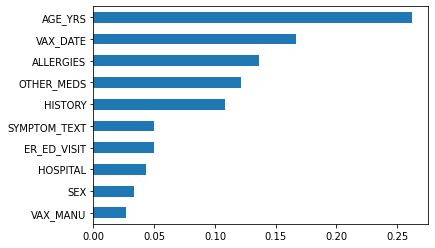

In [ ]:
# 특성 중요도 확인
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

importances.sort_values().plot.barh();

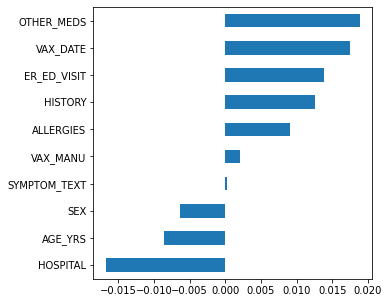

In [29]:
enc = TargetEncoder(min_samples_leaf=10, smoothing=550.0)
imp = IterativeImputer()

X_train_enc = enc.fit_transform(X_train,y_train)
X_val_enc = enc.transform(X_val)
X_train_imp = imp.fit_transform(X_train_enc, y_train)
X_val_imp = imp.transform(X_val_enc)

model_rf = RandomForestClassifier(random_state=10, n_estimators=260, max_depth = 10)
model_rf.fit(X_train_imp, y_train)

# permuter 정의
permuter = PermutationImportance(
    model_rf,
    scoring='f1',
    n_iter=5,
    random_state=10
)

permuter.fit(X_val_imp, y_val)

#특성 중요도를 확인합니다
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values().plot.barh();

In [23]:
features = X_train.columns.tolist()
features.remove('SYMPTOM_TEXT')
X_train_selected = X_train[features]
X_val_selected = X_val[features]

#모델을 다시 훈련시킵니다.
pipe_rf = make_pipeline(
    TargetEncoder(smoothing = 550.0, min_samples_leaf = 10),
    IterativeImputer(),
    RandomForestClassifier(random_state=10, n_estimators = 260, max_depth=10)
)

pipe_rf.fit(X_train_selected, y_train)
print('permute 후 검증 정확도: ', accuracy_score(pipe_rf.predict(X_val_selected), y_val))

permute 후 검증 정확도:  0.6207357859531772


##👩🏻‍💻**두 번째 모델**

* **Imputer:** iterative_imputer
* **Encoder:** target encoder
* **Model:** XGBooster

In [ ]:
warnings.filterwarnings(action='ignore')

pipe = make_pipeline(
    TargetEncoder(),
    IterativeImputer(), 
    XGBClassifier(random_state=10, n_jobs=-1)
)

# 튜닝할 하이퍼파라미터의 범위를 지정
dists = {
    'xgbclassifier__max_depth': range(1,10,1), 
    'xgbclassifier__learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    'xgbclassifier__n_estimator': range(100,120,1)
}

search = GridSearchCV(pipe, 
                      param_grid=dists, 
                      cv=3, 
                      scoring='accuracy',  
                      verbose=1,
                      n_jobs=-1
)

search.fit(X_train_selected, y_train)
print('최적의 하이퍼 파라미터:', search.best_params_)
print("Accuracy score: ", search.best_score_);

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed: 37.4min finished


최적의 하이퍼 파라미터: {'xgbclassifier__learning_rate': 0.5, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimator': 100}
Accuracy score:  0.6291584919732368


In [ ]:
pipe = search.best_estimator_
pipe.fit(X_train_selected, y_train)

y_pred = pipe.predict(X_val_selected)
print('검증 정확도: ', accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred))

검증 정확도:  0.6167224080267558
              precision    recall  f1-score   support

         0.0       0.59      0.74      0.66       750
         1.0       0.65      0.49      0.56       745

    accuracy                           0.62      1495
   macro avg       0.62      0.62      0.61      1495
weighted avg       0.62      0.62      0.61      1495



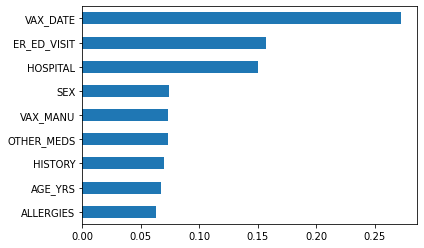

In [ ]:
# 특성 중요도 확인
xgb = pipe.named_steps['xgbclassifier']
importances = pd.Series(xgb.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

importances.sort_values().plot.barh();

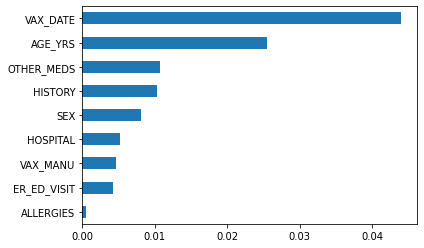

In [ ]:
enc = TargetEncoder()
imp = IterativeImputer()

X_train_enc = enc.fit_transform(X_train_selected,y_train)
X_val_enc = enc.transform(X_val_selected)
X_train_imp = imp.fit_transform(X_train_enc, y_train)
X_val_imp = imp.transform(X_val_enc)

model_xgb = XGBClassifier(random_state=10, n_jobs=-1, learning_rate=0.5, max_depth = 1, n_estimator=100)
model_xgb.fit(X_train_imp, y_train)

# permuter 정의
permuter = PermutationImportance(
    model_rf,
    scoring='accuracy',
    n_iter=5,
    random_state=10
)

permuter.fit(X_val_imp, y_val)

#특성 중요도를 확인합니다
feature_names = X_val_selected.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values().plot.barh();

##👩🏻‍💻**세 번째 모델**

* **Imputer:** iterative_imputer
* **Encoder:** target encoder
* **Model:** XGBooster

첫 번째 모델에서 확인한 중요도가 낮은 특성을 제외하고 모델을 다시 만들어 하이퍼파라미터 튜닝을 하겠습니다.

In [ ]:
warnings.filterwarnings(action='ignore')

pipe = make_pipeline(
    TargetEncoder(), 
    IterativeImputer(), 
    RandomForestClassifier(random_state=10)
)

dists = {  
    'randomforestclassifier__n_estimators': [100,110,120,130],
    'randomforestclassifier__max_depth': [None,10,20,30,40],
    'randomforestclassifier__min_samples_leaf': range(0,10,1)
}

clf = GridSearchCV(
    pipe, 
    param_grid=dists, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)
print('최적의 하이퍼 파라미터:', clf.best_params_)
print("Accuracy: ", clf.best_score_)  

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.0min finished


최적의 하이퍼 파라미터: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 9, 'randomforestclassifier__n_estimators': 130}
Accuracy:  0.6293000120193419


In [24]:
warnings.filterwarnings(action='ignore')

pipe = make_pipeline(
    TargetEncoder(), 
    IterativeImputer(), 
    RandomForestClassifier(random_state=10)
)

dists = {  
    'randomforestclassifier__n_estimators': range(125,140,1),
    'randomforestclassifier__min_samples_leaf': range(5,15,1)
}

clf = GridSearchCV(
    pipe, 
    param_grid=dists, 
    cv=3, 
    scoring='accuracy',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train_selected, y_train)
print('최적의 하이퍼 파라미터:', clf.best_params_)
print("Accuracy: ", clf.best_score_)  

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  5.3min finished


최적의 하이퍼 파라미터: {'randomforestclassifier__min_samples_leaf': 13, 'randomforestclassifier__n_estimators': 132}
Accuracy:  0.6300170428104304


In [30]:
pipe_rf_2 = clf.best_estimator_
pipe_rf_2.fit(X_train_selected, y_train)

y_pred = pipe_rf_2.predict(X_val_selected)
print('검증 정확도: ', accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred))

검증 정확도:  0.6301003344481605
              precision    recall  f1-score   support

         0.0       0.62      0.69      0.65       750
         1.0       0.65      0.57      0.60       745

    accuracy                           0.63      1495
   macro avg       0.63      0.63      0.63      1495
weighted avg       0.63      0.63      0.63      1495



In [32]:
y_pred_3 = pipe_rf_2.predict(X_val_selected)
y_pred_proba_3 = pipe_rf_2.predict_proba(X_val_selected)[:, 1]
                                         
fpr_3, tpr_3, thresholds_3 = roc_curve(y_val, y_pred_proba_3)
optimal_idx = np.argmax(tpr_3 - fpr_3)
optimal_threshold = thresholds_3[optimal_idx]
y_pred_optimal = y_pred_proba_3 >= optimal_threshold

print('검증 정확도: ', accuracy_score(y_pred_optimal, y_val))
print(classification_report(y_val, y_pred_optimal))

검증 정확도:  0.6374581939799331
              precision    recall  f1-score   support

         0.0       0.68      0.52      0.59       750
         1.0       0.61      0.76      0.68       745

    accuracy                           0.64      1495
   macro avg       0.65      0.64      0.63      1495
weighted avg       0.65      0.64      0.63      1495



##👾 **모델 비교 및 최종 모델 설정**

In [ ]:
y_pred_1 = pipe_rf.predict(X_val_selected)
y_pred_2 = model_xgb.predict(X_val_imp)

print('검증 정확도 1: ', accuracy_score(y_pred_1, y_val))
print('검증 정확도 2: ', accuracy_score(y_pred_2, y_val))
print('검증 정확도 3: ', accuracy_score(y_pred_optimal, y_val))

검증 정확도 1:  0.6207357859531772
검증 정확도 2:  0.6167224080267558
검증 정확도 3:  0.6374581939799331


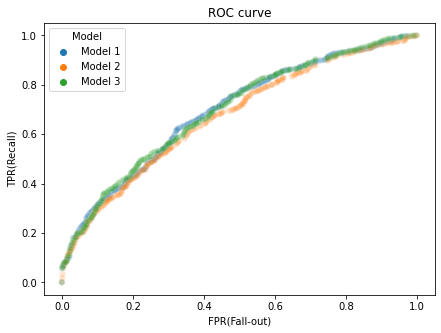

In [ ]:
y_pred_1 = pipe_rf.predict(X_val_selected)
y_pred_2 = model_xgb.predict(X_val_imp)

pred_proba_1 = pipe_rf.predict_proba(X_val_selected)[:, 1]
pred_proba_2 = model_xgb.predict_proba(X_val_imp)[:, 1]
                                         
fpr_1, tpr_1, thresholds_1 = roc_curve(y_val, pred_proba_1)
mdl_1 = ['Model 1']*len(fpr_1)

fpr_2, tpr_2, thresholds_2 = roc_curve(y_val, pred_proba_2)
mdl_2 = ['Model 2']*len(fpr_2)

mdl_3 = ['Model 3']*len(fpr_3)

roc_1 = pd.DataFrame({
    'FPR(Fall-out)': fpr_1,
    'TPRate(Recall)': tpr_1, 
    'Threshold': thresholds_1,
    'Model' : mdl_1})
roc_2 = pd.DataFrame({
    'FPR(Fall-out)': fpr_2,
    'TPRate(Recall)': tpr_2, 
    'Threshold': thresholds_2,
    'Model' : mdl_2})
roc_3 = pd.DataFrame({
    'FPR(Fall-out)': fpr_3,
    'TPRate(Recall)': tpr_3, 
    'Threshold': thresholds_3,
    'Model' : mdl_3})

roc_compare = pd.concat([roc_1, roc_2, roc_3])

plt.figure(figsize=(7, 5))
sns.scatterplot(data=roc_compare, x='FPR(Fall-out)', y='TPRate(Recall)', hue='Model', alpha=0.1)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [ ]:
auc_score_1 = roc_auc_score(y_val, pred_proba_1)
auc_score_2 = roc_auc_score(y_val, pred_proba_2)
auc_score_3 = roc_auc_score(y_val, y_pred_proba_3)
print('Model#1 AUC score:',auc_score_1)
print('Model#2 AUC score:',auc_score_2)
print('Model#3 AUC score:',auc_score_3)

Model#1 AUC score: 0.6929387024608501
Model#2 AUC score: 0.6723185682326622
Model#3 AUC score: 0.694323937360179


In [ ]:
features = X_train.columns.tolist()
features.remove('SYMPTOM_TEXT')
X_test_selected = X_test[features]

y_pred_3 = pipe_rf_2.predict(X_test_selected)

print('테스트 정확도: ', accuracy_score(y_pred_3, y_test))

테스트 정확도:  0.6488294314381271


#**4. 모델 해석** 

In [43]:
features = X_train.columns.tolist()
features.remove('SYMPTOM_TEXT')
X_test_selected = X_test[features]

enc = TargetEncoder()
imp = IterativeImputer()

X_train_enc = enc.fit_transform(X_train_selected,y_train)
X_test_enc = enc.transform(X_test_selected)
X_train_imp = imp.fit_transform(X_train_enc, y_train)
X_test_imp = imp.transform(X_test_enc)

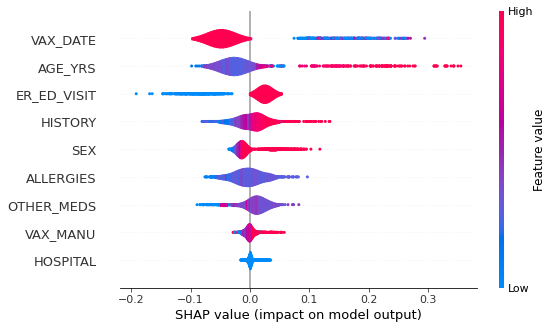

In [46]:
shap.initjs()

X_test = pd.DataFrame(columns=X_test_selected.columns, data = X_test_imp)
model = pipe_rf_2.named_steps['randomforestclassifier']

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, plot_type="violin")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


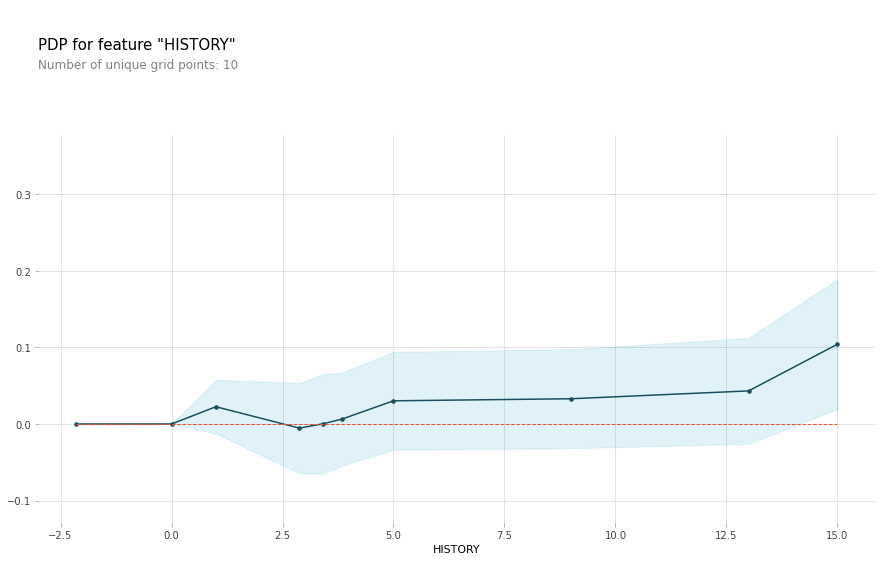

In [ ]:
feature = 'HISTORY'

isolated = pdp_isolate(
    model= model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='percentile',
    num_grid_points = 15
)
pdp_plot(isolated, feature_name=feature);

In [47]:
row = X_test_enc.iloc[[852]]

print('실제 사망 또는 장애 여부:',y_test.iloc[852])
print('예측된 사망 또는 장애 여부:',pipe_rf_2.predict(row))

실제 사망 또는 장애 여부: 1.0
예측된 사망 또는 장애 여부: [1.]


In [48]:
row

,VAX_MANU,AGE_YRS,SEX,HOSPITAL,VAX_DATE,OTHER_MEDS,HISTORY,ER_ED_VISIT,ALLERGIES
13518,0.481967,52.0,0.467188,0.49828,1.0,13.0,12.0,1,NaN


In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1],
    features=row
)